# Cryptocurrency Trader Agent
Deep Q-Learning Implementation

In [1]:
from environment.env import Coin
from environment.portfolio import Portfolio
from environment.simulator import Simulator
from environment.simulator import Action

### Neural Networks

In [2]:
# Q Value Function Approximator
# Neural Network Implementation

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.models import load_model

class QValue_NN:
    
    # init neural network
    def __init__(self, state_size, action_size, units):
        # define input and target shapes
        self._state_size = state_size
        self._action_size = action_size

        self._units = units
        
        # init model
        self._model = self._build_model()
    
    
    # define loss function
    def _huber_loss(self, target, prediction):
        # sqrt(1+error^2)-1
        error = prediction - target
        return K.mean(K.sqrt(1+K.square(error))-1, axis=-1)

    
    # neural net for Deep-Q Learning Model
    def _build_model(self):
        model = Sequential()
        model.add(Dense(self._units, input_dim=self._state_size, activation='relu'))
        model.add(Dense(self._units, activation='relu'))
        model.add(Dense(self._action_size, activation='linear'))
        model.compile(loss=self._huber_loss, optimizer='adam')
        return model

    
    # online training
    def train(self, state, qvalues):
        state_reshape = np.reshape(state, [1, len(state)])
        self._model.fit(state_reshape, qvalues, epochs=1, verbose=0)
    
    
    # get q-values based on state
    def predict(self, state):
        state_reshape = np.reshape(state, [1, len(state)])
        return self._model.predict(state_reshape)
    
    def set_weights(self, model_weights):
        self._model.set_weights(model_weights)
        
    def get_weights(self):
        return self._model.get_weights()
    
    def save(self, path):
        self._model.save_weights(path)
        
    def load(self, path):
        self._model.load_weights(path)
    

Using TensorFlow backend.


### Deep Q Learning Implementation

In [5]:
# Cryptocurrency Trader Q-Learning Implementation

import random
import numpy as np
from collections import deque

class Crypto_Trader:

    def __init__(self, gamma = 0.95, epsilon = 1.0, epsilon_min = 0.01, epsilon_decay = 0.99, num_episodes = 1000,
                num_neutron = 24, num_coins_per_order = 100, init_capital = 1000, 
                coin_name = 'ethereum', recent_k = 0):

        self.memory = deque(maxlen=2000)
        self.batch_size = 300
        
        # Reward Discount Rate
        self.gamma = gamma

        # Esiplon (exploration factor)
        self.epsilon = epsilon
        
        self.epsilon_min = epsilon_min
        
        # Reduce exploration overtime
        self.epsilon_decay = epsilon_decay

        # number of episodes for training
        self.num_episodes = num_episodes
        
        # init simulator
        self.coin_name = coin_name
        self.simulator = Simulator(num_coins_per_order, init_capital, Coin(coin_name, recent_k))
        
        # init NN model
        self.model = QValue_NN(self.simulator.get_state_size(), self.simulator.get_action_size(), num_neutron)
        self.target_model = QValue_NN(self.simulator.get_state_size(), self.simulator.get_action_size(), num_neutron)

        
    def plot_coin_price(self):
        self.simulator.plot_coin_price()
        
        
    def act(self, state, epsilon):
        # Choose action by e-greedy
        if np.random.rand() < epsilon:
            #print 'random'
            return self.simulator.get_ran_action()
        
        # Get Q values, choose action by Q values
        act_values = self.model.predict(state)
        return Action(np.argmax(act_values[0]))
    
    
    def remember(self, state, action, reward, next_state, isDone):
        self.memory.append((state, action, reward, next_state, isDone))
        
        
    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())
        
        
    def replay(self):
        minibatch = random.sample(self.memory, self.batch_size)
        
        for state, action, reward, next_state, isDone in minibatch:
            target = self.model.predict(state)
            if isDone:
                target[0][action.value] = reward
            else:
                a = self.model.predict(next_state)[0]
                t = self.target_model.predict(next_state)[0]
                target[0][action.value] = reward + self.gamma * t[np.argmax(a)]
            self.model.train(state, target)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
        
    def train(self):
        for i in range(self.num_episodes):
            
            self.simulator.reset()
            state = self.simulator.get_current_state()
            
            while (True):
                
                action = self.act(state, self.epsilon)
                #print action
                
                # step to the next state and reward based on action
                next_state, reward, isDone = self.simulator.act_and_step(action)
                #print next_state
                #print reward
                
                self.remember(state, action, reward, next_state, isDone)
                state = next_state
                
                if isDone:
                    self.update_target_model()
                    print("episode: {}/{}, reward: {}, epsilon: {:.2}"
                          .format(i+1, self.num_episodes, reward, self.epsilon))
                    #print self.simulator.get_current_holdings()
                    break
            
            if len(self.memory) > self.batch_size:        
                self.replay()
                
        self.model.save('model/{}.model.v3.h5'.format(self.coin_name))
        
    
    def test(self, epsilon = None):
        if epsilon is None:
            epsilon = self.epsilon
        
        self.simulator.reset()
        self.model.load('model/{}.model.v3.h5'.format(self.coin_name))
        state = self.simulator.get_current_state()
        while (True):
                
            action = self.act(state, epsilon)
            print action
                
            # step to the next state and reward based on action
            next_state, reward, isDone = self.simulator.act_and_step(action)
                
            self.remember(state, action, reward, next_state, isDone)
            state = next_state
                
            if isDone:
                print("Test run: reward: {}, holdings: {}"
                          .format(reward, self.simulator.get_current_holdings()))
                break
        

In [6]:
trader = Crypto_Trader(num_episodes = 800, epsilon_min = 0, coin_name = 'ethereum', recent_k = 150)

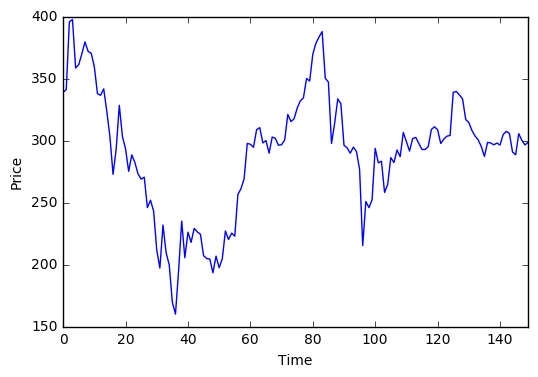

In [7]:
trader.plot_coin_price()

In [8]:
trader.train()

episode: 1/800, reward: 4.10981352954, epsilon: 1.0
episode: 2/800, reward: 16.0663116947, epsilon: 1.0
episode: 3/800, reward: -1.38668933315, epsilon: 1.0
episode: 4/800, reward: 12.8892599029, epsilon: 0.99
episode: 5/800, reward: -40.3269912924, epsilon: 0.98
episode: 6/800, reward: 103.12816249, epsilon: 0.97
episode: 7/800, reward: -37.7114325964, epsilon: 0.96
episode: 8/800, reward: -0.737189074457, epsilon: 0.95
episode: 9/800, reward: -7.35180997055, epsilon: 0.94
episode: 10/800, reward: -23.085262194, epsilon: 0.93
episode: 11/800, reward: 9.72648350944, epsilon: 0.92
episode: 12/800, reward: -43.9083242264, epsilon: 0.91
episode: 13/800, reward: 25.3916280256, epsilon: 0.9
episode: 14/800, reward: -44.8371572068, epsilon: 0.9
episode: 15/800, reward: 0.910919438271, epsilon: 0.89
episode: 16/800, reward: 36.5567868016, epsilon: 0.88
episode: 17/800, reward: -13.6224424119, epsilon: 0.87
episode: 18/800, reward: 30.546168573, epsilon: 0.86
episode: 19/800, reward: -31.85196

In [9]:
trader.test(epsilon = 0)

Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.SELL
Action.HOLD
Action.HOLD
Action.HOLD
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
A

## Bollinger Band Model

In [11]:
def run_bollinger_band(num_coins_per_order, init_capital, coin_name, recent_k):
    simulator = Simulator(num_coins_per_order, init_capital, Coin(coin_name, recent_k))
    
    while True:
        current_price, current_value, sharpe_ratio, check_upper_band, check_lower_band = simulator.get_current_state()
        if check_lower_band:
            state, reward, isDone = simulator.act_and_step(Action.BUY)

        elif check_upper_band:
            state, reward, isDone = simulator.act_and_step(Action.SELL)

        else:
            state, reward, isDone = simulator.act_and_step(Action.HOLD)

        if isDone:
            break

    return simulator

In [12]:
simulator_100_per_order = run_bollinger_band(100, 1000, "ethereum", 150)
print simulator_100_per_order.get_current_holdings()

0.00 coins, 1840.74 cash, 1840.74 current value, 84.07 percent returns
